# Déploiement d'un modèle de Computer Vision pour la détection d'objets

Dans ce Notebook, on va travailler sur le déploiement d'un modèle de computer vision entrainé pour la détection d'objets dans les images. On va utiliser un modèle pré-entraîné appelé YOLOV3.

## La détection d'objets avec YOLOV3

### Examen des images

Jetons un coup d'œil aux images qui seront transmises au modèle YOLOV3. Cela apportera un aperçu sur quel type d'objets communs sont présents pour la détection. Ces images font partie du jeu de données ImageNet.

In [1]:
# pip install --upgrade opencv-python

In [2]:
# pip install python-multipart

In [3]:
from IPython.display import Image, display
import cv2
import cvlib as cv
from cvlib.object_detection import draw_bbox
import numpy as np
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse

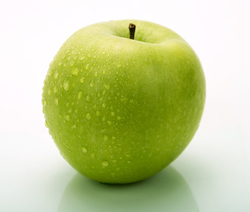

In [4]:
filename=r"C:\Users\Utilisateur\Downloads\apple.jpg"
display(Image(filename))

### Présentation du modèle

On va utiliser cvlib, qui est une bibliothèque très simple et puissante pour la détection d'objets d'OpenCV.
On va utiliser la fonction detect_common_objects, qui prend une image formatée en tableau numpy et renvoie :

- `bbox`: liste de liste contenant les coordonnées de la boîte englobante pour les objets détectés. 

        Example:
    
    ```python
        [[32, 76, 128, 192]]
    ```     
         
        
- `label`: liste des labels des objets détectés.
    
        Example:
    ```python
        ['apple']  
    ```


- `conf`: liste des scores de confiance pour les objets détectés.

        Example:
        
    ```python
        [0.6187325716018677]
    ```

### Création de la fonction detect_and_draw_box

Définissons la fonction detect_and_draw_box qui prend comme arguments d'entrée :

- le nom de fichier d'un fichier sur votre système
- le modèle
- le niveau de confiance.

Avec ces entrées, on détecte les objets communs dans l'image et enregistre une nouvelle image affichant les boîtes englobantes . Ces nouvelles images seront enregistrées dans le répertoire `images_with_boxes`.

La fonction `detect_common_objects` utilise le modèle `yolov3` par défaut. Cependant, il existe une autre option disponible qui nécessite moins de puissance de calcul. Il s'agit de `yolov3-tiny`, ce modèle est conçu pour les environnements contraints qui ne peuvent pas stocker de gros modèles. Parcontre, les résultats sont moins précis que le modèle complet. Cependant, cela fonctionne toujours assez bien.

La sortie du modèle est un vecteur de probabilités de présence de différents objets sur l'image. Le niveau de confiance, détermine le seuil que la probabilité doit dépasser pour signaler qu'un objet donné est détecté sur l'image fournie. Par défaut, `detect_common_objects` utilise une valeur de 0,5 pour ce seuil.

In [5]:
def detect_and_draw_box(filename, model="yolov3-tiny", confidence=0.5):
    """Détecte les objets communs sur une image et crée une nouvelle image avec des cadres de délimitation.

     Arguments :
         filename (str) : nom de fichier de l'image.
         model (str): Soit "yolov3" soit "yolov3-tiny". Par défaut, "yolov3-tiny".
         confidence (float) : niveau de confiance souhaité. La valeur par défaut est 0,5.
    """
    
    # Lecture l'image dans un tableau numpy
    img = cv2.imread(filename)
    
    # Effectuer la détection d'objet
    bbox, label, conf = cv.detect_common_objects(img, confidence=confidence, model=model)
    
    # les objets détectés avec un niveau de confiance
    for l, c in zip(label, conf):
        print(f"Detected object: {l} with confidence level of {c}\n")
        
    # Créer une nouvelle image qui inclut les boîtes englobantes
    output_image = draw_bbox(img, bbox, label, conf)
    
    # Enregistrez l'image 
    new_filename=filename[:-4]+"_box.jpg"
    cv2.imwrite(new_filename, output_image)  
    
    # Montrer l'image avec l'encadrement
    display(Image(new_filename))

Detected object: apple with confidence level of 0.571720540523529



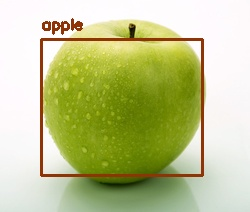

In [6]:
detect_and_draw_box(filename, model="yolov3-tiny", confidence=0.5)

### Optimisation du seuil de confiance

Detected object: apple with confidence level of 0.7649703621864319

Detected object: apple with confidence level of 0.7040488719940186

Detected object: apple with confidence level of 0.6813892126083374

Detected object: orange with confidence level of 0.5133663415908813



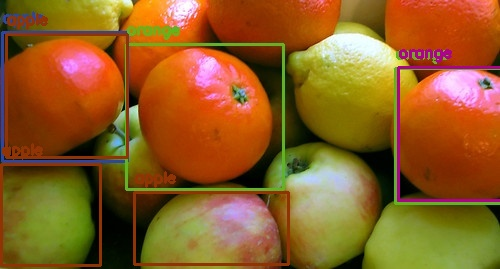

In [7]:
detect_and_draw_box(r"C:\Users\Utilisateur\Downloads\fruits.jpg")

Le modèle n'a pas réussi à détecter plusieurs fruits et a mal classé une orange comme une pomme. Cela peut sembler étrange car il était capable de détecter une pomme auparavant, donc on pourrait penser que le modèle a une représentation juste de l'apparence d'une pomme.
On va essayer avec un niveau de confiance plus faible


Detected object: apple with confidence level of 0.7649703621864319

Detected object: apple with confidence level of 0.7040488719940186

Detected object: apple with confidence level of 0.6813892126083374

Detected object: orange with confidence level of 0.5133663415908813

Detected object: orange with confidence level of 0.48231998085975647

Detected object: apple with confidence level of 0.4803771674633026

Detected object: orange with confidence level of 0.2577894926071167



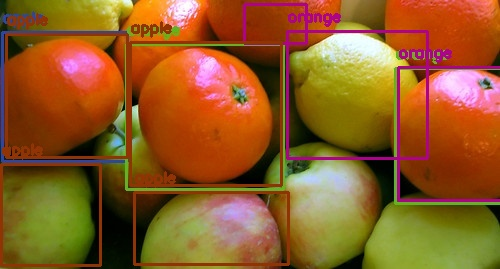

In [8]:
detect_and_draw_box(r"C:\Users\Utilisateur\Downloads\fruits.jpg", confidence=0.25)

En abaissant le niveau de confiance, le modèle détecte avec succès la plupart des fruits. Quant aux cas où le modèle a mal classé les fruits, cela est du au fait que le modèle 'yolov3-tiny' est moins précis.

## Déploiement du modèle avec fastAPI


### Mise du modèle de détection d'objets dans un serveur

In [9]:
# Création de l'instance FastAPI
app = FastAPI(title='Déploiement de modèle de computer vision avec FastAPI')

# lister les modèles 
class Model(str, Enum):
    yolov3tiny = "yolov3-tiny"
    yolov3 = "yolov3"

@app.get("/")
def home():
    return "Bonjour, l'API fonctionne très bien!"



@app.post("/predict") 
def prediction(model: Model, file: UploadFile = File(...)):

    # Validation des inputs
    filename = file.filename
    fileExtension = filename.split(".")[-1] in ("jpg", "jpeg", "png")
    if not fileExtension:
        raise HTTPException(status_code=415, detail="Unsupported file provided.")
    
    # Lecture d'image sous forme de flux d'octets
    image_stream = io.BytesIO(file.file.read())
    
    # Commencer le stream depuis le début (position zero)
    image_stream.seek(0)
    
    # Mise dans numpy array
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    
    # Decodage en image
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    
    # Lancement de la detection d'objets
    bbox, label, conf = cv.detect_common_objects(image, model=model)
    
    # Création de l'image includant bounding boxes et labels
    output_image = draw_bbox(image, bbox, label, conf)
    
    # Sauvegarder l'image dans un répertoire dans le serveur
    cv2.imwrite(filename, output_image)
    
    # Lecture de l'image en mode binaire
    file_image = open(filename, mode="rb")
    
    return StreamingResponse(file_image, media_type="image/jpeg")


In [ ]:
# Allows the server to be run in this interactive environment
nest_asyncio.apply()

# This is an alias for localhost which means this particular machine
host = "127.0.0.1"

# Spin up the server!    
uvicorn.run(app, host=host, port=8000)

INFO:     Started server process [16040]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:62656 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:62656 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:62658 - "POST /predict?model=yolov3-tiny HTTP/1.1" 200 OK
